# GeekBrains, ML in Business
# Lesson 3 Homework

Ссылки:
- https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic

**Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix


%matplotlib inline

**Функции и классы для заданий**

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

Функция показа ROC кривой.

In [3]:
def show_roc_curve(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

Функция валидации модели.

In [4]:
def validate_model(model, X_train, X_test, y_train, y_test):
    # CV
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # Train model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Find optimal threshold
    beta = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(f1)

    # Show ROC curve
    show_roc_curve(y_test, y_pred)

    # Return metrics
    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f1[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std}

**Работа с данными**

Читаем данные.

In [16]:
df = pd.read_csv('train_case2.csv', ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [17]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Делим датасет.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['cardio']), 
                                                    df['cardio'],
                                                    random_state=0)

Пайплайны трансформаций.

In [7]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем пайплайны признаков в один
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)    

## Задание 1, 2
1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.
2. При обучении моделей обязательно использовать кроссвалидацию.
3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики).

### Решение Заданий 1, 2, 3

Датафрейм для метрик.

In [8]:
metrics_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])

Логистическая регрессия.

In [9]:
clf_logreg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

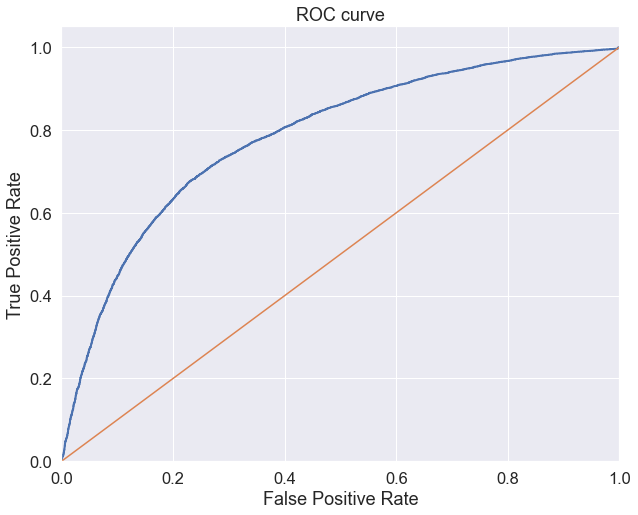

In [10]:
metrics_log = validate_model(clf_logreg, X_train, X_test, y_train, y_test)
metrics_df = metrics_df.append(metrics_log, ignore_index=True)

Случайный лес.

In [11]:
clf_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

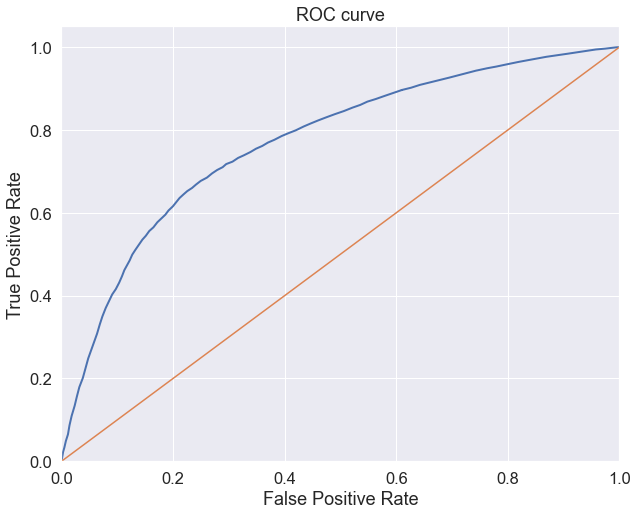

In [12]:
metrics_rf = validate_model(clf_rf, X_train, X_test, y_train, y_test)
metrics_df = metrics_df.append(metrics_rf, ignore_index=True)

Градиентный бустинг.

In [13]:
clf_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

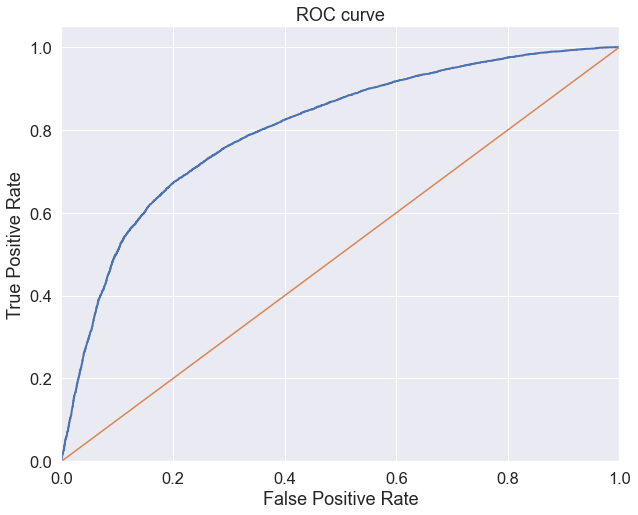

In [14]:
metrics_gb = validate_model(clf_gb, X_train, X_test, y_train, y_test)
metrics_df = metrics_df.append(metrics_gb, ignore_index=True)

Метрики.

In [15]:
metrics_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
0,0.647431,0.837558,0.730323,0.784035,0.786450,0.004705
1,0.642669,0.815553,0.718863,0.771037,0.774612,0.002827
2,0.697848,0.788134,0.740248,0.802615,0.802095,0.003615


## Задание 4
Сделать выводы о том, какая модель справилась с задачей лучше других.

### Решение Задания 4

Тестировались только базовые модели - без настройки гиперпараметров.

Модель градиентного бустинга справилась лучше остальных по всем метрикам, кроме recall - она смогла лучше выявить закономерности в датасете, была более точной.

Что интересно, модель логистической регрессии показала себя немного лучше модели случайного леса.

Если самое важное для модели - recall, то стоит выбрать модель логистической регрессии. Иначе, стоит выбрать модель градиентного бустинга.

## Задание 5*
Какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000)

P.S.
В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:
- Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
- Допустим, у нас две модели:
  - первая помечает 100 объектов как класс 1, но TP = 90
  - вторая помечает 1000 объектов как класс 1, но TP такой же - 90
- Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Решение Задания 5*

PR-кривая здесь подойдет лучше.

False Positive Rate у ROC-кривой изменится незначительно от одной модели к другой - количество TN (верно определенного класса 0) настолько велико, что FP = 10 или FP = 910 мало влияет на показатель.

Напротив, Precision у PR-кривой значительно упадет у второй модели по сравнению с первой - количество FP повышается в ~90 раз при таком же TP.